This notebook contains code for:
1. Baseline Logistic Regression model classifying syllables as either Gurung or Nepali
2. Feature engineering on numerical variables -- specifically, using the distance between each formant (F1, F2, and F3) as features rather than raw measures in Hertz
3. Logistic Regression model fit after engineering the numerical variables
4. K-Nearest-Neighbors model fit after engineering the numerical variables

All models include cross-validation with 5 folds and a confusion matrix with a plot.

## Import Tools

In [125]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

## Import Pickled Dataframe of Nepali and Gurung Syllables
Data includes 5 speakers of each language saying ~92 words 3x each.

In [126]:
df = pd.read_pickle('all_gur_and_nep_data.csv')
df.head()

,language,speaker,time,word,phoneme,duration,F1,F2,F3,nasal,syllable_number,onset_c_place,onset_c_manner,laryngeal,coda
0,Nepali,1,8.422885,one,e,0.340285,570.820088,2773.608460,3421.056785,0,1,none,none,0,1
1,Nepali,1,9.794364,one,e,0.363759,555.260091,2818.847185,3332.194967,0,1,none,none,0,1
2,Nepali,1,10.912042,one,e,0.179386,522.733404,2736.485673,3301.971337,0,1,none,none,0,1
3,Nepali,1,20.259035,two,i,0.365618,449.909150,2762.010722,3349.317399,0,1,labial,sonorant,0,1
4,Nepali,1,21.365301,two,i,0.360141,388.329390,2799.204021,3345.667876,0,1,labial,sonorant,0,1


In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5099 entries, 0 to 5098
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   language         5099 non-null   object 
 1   speaker          5099 non-null   int64  
 2   time             5099 non-null   float64
 3   word             5099 non-null   object 
 4   phoneme          5099 non-null   object 
 5   duration         5099 non-null   float64
 6   F1               5099 non-null   float64
 7   F2               5099 non-null   float64
 8   F3               5099 non-null   float64
 9   nasal            5099 non-null   int64  
 10  syllable_number  5099 non-null   int64  
 11  onset_c_place    5099 non-null   object 
 12  onset_c_manner   5099 non-null   object 
 13  laryngeal        5099 non-null   int64  
 14  coda             5099 non-null   int64  
dtypes: float64(5), int64(5), object(5)
memory usage: 597.7+ KB


In [128]:
df.shape

(5099, 15)

In [129]:
df.language.value_counts()

Nepali    2786
Gurung    2313
Name: language, dtype: int64

## 1. Baseline Linear Regression Pipeline

In [130]:
X = df.loc[:,'duration':'coda']
y = df['language']

In [131]:
## Adapted from https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
## Code creates a pipline to scale the numeric data and one-hot-encode the categorical data.
numeric_features = ["duration", "F1", "F2", "F3"]
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())])

categorical_features = ["nasal", "syllable_number", "onset_c_place", "onset_c_manner", "laryngeal", "coda"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers =[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("cross validation scores:", scores)
print("model score: %.3f" % clf.score(X_test, y_test))


cross validation scores: [0.75980392 0.76838235 0.75       0.79044118 0.7803681 ]
model score: 0.767


In [132]:
## Confusion Matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[328, 119],
       [119, 454]])

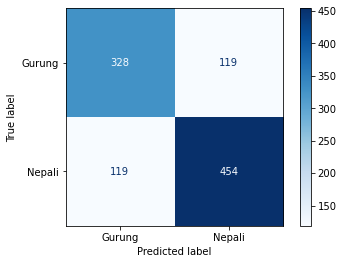

In [133]:
## Plot confusion matrix, code adapted from example here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('baseline_regression_confusion_matrix.png')
plt.show()

## 2. Numerical Feature Engineering
I chose not to do any speaker-specific engineering here since the purpose of this model is to generalize over different pronounciations and then make categorical classification judegments. Traditionally in discriptive phonetics one would want to normalize the formant data for each speaker to account for the length and shape of their vocal tract; however, this depends on having labeled vowels at the extremes of their vowel space to perform this calcuation. In a real world application of this model, you would not have this data available when encountering a new speaker and trying to classsify their speech, so it doesn't make sense to do so for the training data here.

In [134]:
df.head()

,language,speaker,time,word,phoneme,duration,F1,F2,F3,nasal,syllable_number,onset_c_place,onset_c_manner,laryngeal,coda
0,Nepali,1,8.422885,one,e,0.340285,570.820088,2773.608460,3421.056785,0,1,none,none,0,1
1,Nepali,1,9.794364,one,e,0.363759,555.260091,2818.847185,3332.194967,0,1,none,none,0,1
2,Nepali,1,10.912042,one,e,0.179386,522.733404,2736.485673,3301.971337,0,1,none,none,0,1
3,Nepali,1,20.259035,two,i,0.365618,449.909150,2762.010722,3349.317399,0,1,labial,sonorant,0,1
4,Nepali,1,21.365301,two,i,0.360141,388.329390,2799.204021,3345.667876,0,1,labial,sonorant,0,1


In [135]:
## Use the distance between the first and second formants as a feature
df["F2-F1"] = df['F2'] - df['F1']
df.head()

,language,speaker,time,word,phoneme,duration,F1,F2,F3,nasal,syllable_number,onset_c_place,onset_c_manner,laryngeal,coda,F2-F1
0,Nepali,1,8.422885,one,e,0.340285,570.820088,2773.608460,3421.056785,0,1,none,none,0,1,2202.788372
1,Nepali,1,9.794364,one,e,0.363759,555.260091,2818.847185,3332.194967,0,1,none,none,0,1,2263.587094
2,Nepali,1,10.912042,one,e,0.179386,522.733404,2736.485673,3301.971337,0,1,none,none,0,1,2213.752269
3,Nepali,1,20.259035,two,i,0.365618,449.909150,2762.010722,3349.317399,0,1,labial,sonorant,0,1,2312.101572
4,Nepali,1,21.365301,two,i,0.360141,388.329390,2799.204021,3345.667876,0,1,labial,sonorant,0,1,2410.874630


In [136]:
## Use the distance between the third and second formants as a feature
df["F3-F2"] = df['F3'] - df['F2']
df.head()

,language,speaker,time,word,phoneme,duration,F1,F2,F3,nasal,syllable_number,onset_c_place,onset_c_manner,laryngeal,coda,F2-F1,F3-F2
0,Nepali,1,8.422885,one,e,0.340285,570.820088,2773.608460,3421.056785,0,1,none,none,0,1,2202.788372,647.448325
1,Nepali,1,9.794364,one,e,0.363759,555.260091,2818.847185,3332.194967,0,1,none,none,0,1,2263.587094,513.347782
2,Nepali,1,10.912042,one,e,0.179386,522.733404,2736.485673,3301.971337,0,1,none,none,0,1,2213.752269,565.485664
3,Nepali,1,20.259035,two,i,0.365618,449.909150,2762.010722,3349.317399,0,1,labial,sonorant,0,1,2312.101572,587.306677
4,Nepali,1,21.365301,two,i,0.360141,388.329390,2799.204021,3345.667876,0,1,labial,sonorant,0,1,2410.874630,546.463855


In [137]:
## Use the distance between the third and first formants as a feature
df["F3-F1"] = df['F3'] - df['F1']
df.head()

,language,speaker,time,word,phoneme,duration,F1,F2,F3,nasal,syllable_number,onset_c_place,onset_c_manner,laryngeal,coda,F2-F1,F3-F2,F3-F1
0,Nepali,1,8.422885,one,e,0.340285,570.820088,2773.608460,3421.056785,0,1,none,none,0,1,2202.788372,647.448325,2850.236697
1,Nepali,1,9.794364,one,e,0.363759,555.260091,2818.847185,3332.194967,0,1,none,none,0,1,2263.587094,513.347782,2776.934876
2,Nepali,1,10.912042,one,e,0.179386,522.733404,2736.485673,3301.971337,0,1,none,none,0,1,2213.752269,565.485664,2779.237933
3,Nepali,1,20.259035,two,i,0.365618,449.909150,2762.010722,3349.317399,0,1,labial,sonorant,0,1,2312.101572,587.306677,2899.408249
4,Nepali,1,21.365301,two,i,0.360141,388.329390,2799.204021,3345.667876,0,1,labial,sonorant,0,1,2410.874630,546.463855,2957.338485


In [138]:
## Drop raw formant columns
df.drop(columns = ['F1', 'F2', 'F3'], inplace = True)

In [139]:
df.head()

,language,speaker,time,word,phoneme,duration,nasal,syllable_number,onset_c_place,onset_c_manner,laryngeal,coda,F2-F1,F3-F2,F3-F1
0,Nepali,1,8.422885,one,e,0.340285,0,1,none,none,0,1,2202.788372,647.448325,2850.236697
1,Nepali,1,9.794364,one,e,0.363759,0,1,none,none,0,1,2263.587094,513.347782,2776.934876
2,Nepali,1,10.912042,one,e,0.179386,0,1,none,none,0,1,2213.752269,565.485664,2779.237933
3,Nepali,1,20.259035,two,i,0.365618,0,1,labial,sonorant,0,1,2312.101572,587.306677,2899.408249
4,Nepali,1,21.365301,two,i,0.360141,0,1,labial,sonorant,0,1,2410.874630,546.463855,2957.338485


In [140]:
X = df.loc[:,'duration':'F3-F1']
y = df['language']

## 3. Logistic Regression with Engineered Formant Features

In [141]:
## Logistic regression with engineered features -- score actually decreases slightly compared to original model
## Adapted from https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
## Code creates a pipline to scale the numeric data and one-hot-encode the categorical data.
numeric_features = ["duration", "F2-F1", "F3-F2", "F3-F1"]
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())])

categorical_features = ["nasal", "syllable_number", "onset_c_place", "onset_c_manner", "laryngeal", "coda"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers =[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("cross validation scores:", scores)
print("model score: %.3f" % clf.score(X_test, y_test))

cross validation scores: [0.75245098 0.76838235 0.75857843 0.78308824 0.78282209]
model score: 0.763


In [142]:
## Confusion Matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[328, 119],
       [123, 450]])

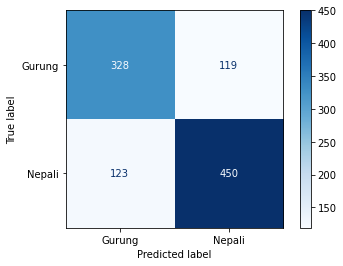

In [143]:
## Plot confusion matrix, code adapted from example here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('engineered_regression_confusion_matrix.png')
plt.show()

## 4. KNN with Engineered Formant Features

In [144]:
## K-Nearest-Neighbors with engineered features -- score is better than Logistic Regression model, but still not as 
## accurate as a KNN model on the original features
## Adapted from https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html
## Code creates a pipline to scale the numeric data and one-hot-encode the categorical data.
numeric_features = ["duration", "F2-F1", "F3-F2", "F3-F1"]
numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),("scaler", StandardScaler())])

categorical_features = ["nasal", "syllable_number", "onset_c_place", "onset_c_manner", "laryngeal", "coda"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers =[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ])

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", KNeighborsClassifier())])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

clf.fit(X_train, y_train)
scores = cross_val_score(clf, X_train, y_train, cv=5)
print("cross validation scores:", scores)
print("model score: %.3f" % clf.score(X_test, y_test))

cross validation scores: [0.86519608 0.89583333 0.88235294 0.88357843 0.87361963]
model score: 0.899


In [145]:
## Confusion Matrix
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[388,  59],
       [ 44, 529]])

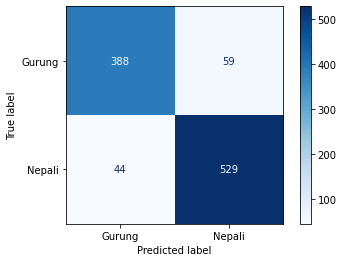

In [146]:
## Plot confusion matrix, code adapted from example here: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html
predictions = clf.predict(X_test)
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.savefig('engineered_KNN_confusion_matrix.png')
plt.show()